In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import itertools
import warnings
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")

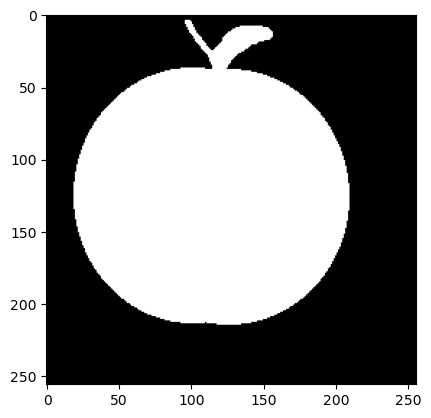

In [174]:
sample = cv2.imread("mpeg7shapeB/train/apple-1.png", cv2.IMREAD_GRAYSCALE)
contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)
plt.imshow(sample, cmap="gray")

In [182]:
def basic_shape(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    convex_hull = cv2.convexHull(contour)
    convex_hull_area = cv2.contourArea(convex_hull)
    convexity = area / convex_hull_area

    x, y, w, h = cv2.boundingRect(contour)
    rectangularity = area / (w * h) 

    circularity = (perimeter**2)/area

    cov_matrix = np.cov(contour.reshape(-1, 2).T)
    eigenvalues= np.sort(np.linalg.eig(cov_matrix)[0])[::-1]
    eccentricity = eigenvalues[1] / eigenvalues[0]
    
    print("Area:", area)
    print("Perimeter:", perimeter)
    print("Convexity:", convexity)
    print("Circularity:", circularity)
    print("Rectangularity:", rectangularity)
    print("Eccentricity:", eccentricity)

basic_shape(contour)


Area: 27947.5
Perimeter: 776.5655764341354
Convexity: 0.9182986133929159
Circularity: 21.57810517944292
Rectangularity: 0.6934691446862361
Eccentricity: 0.7506861857811268


In [177]:
def fourier_descriptors(contour, n):
    if n == 0:
        return []

    complex_contour = np.array([point[0][0] + 1j * point[0][1] for point in contour])
    fourier_transform = np.fft.fft(complex_contour)
    
    result = fourier_transform[:n]

    # Pad with zeros if the length is smaller than n
    result = np.pad(result, (0, n - len(result)), 'constant')

    return result

fourier_descriptors(contour, 10)

array([37023.        +32560.j        ,   803.03039647 -2599.30948708j,
        1274.72954226 -1793.24866418j,   160.7198414   -409.16502007j,
         480.83092615  -408.45145814j,  -705.40612365  -107.66706434j,
        -741.12547654  -235.49645706j,  -579.09542908  -515.99598519j,
        -215.54289266  -169.27122045j,  -913.76792781 -1230.13054607j])

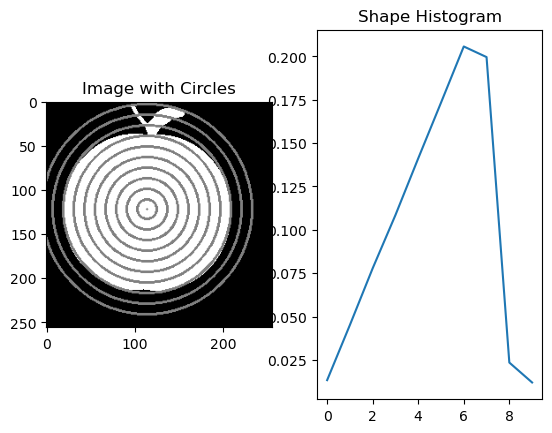

array([0.01329938, 0.04513299, 0.07781551, 0.10851726, 0.14119977,
       0.17331636, 0.2057159 , 0.19959677, 0.02345076, 0.01195529])

In [179]:
def calculate_shape_histogram(contour, image, num_bins=10):
    if num_bins == 0:
        return []
    
    # Calculate the center of mass
    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Calculate the distances from the center to all points in the contour
    distances = np.sqrt((contour[:, 0, 0] - cx) ** 2 + (contour[:, 0, 1] - cy) ** 2)
    # Find the farthest point from the center
    max_radius = int(np.max(distances))

    # Initialize histogram
    histogram = np.zeros(num_bins)

    # Create an image copy to draw circles on
    image_with_circles = image.copy()

    # Iterate over concentric circles and calculate histogram
    for i in range(num_bins):
        # Define inner and outer radius of the circular band
        inner_radius = i * max_radius / num_bins
        outer_radius = (i + 1) * max_radius / num_bins

        # Draw circles on the image
        cv2.circle(image_with_circles, (cx, cy), int(outer_radius), 128, 2)
        cv2.circle(image_with_circles, (cx, cy), int(inner_radius), 128, 2)

        # Create a mask for the circular band
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.circle(mask, (cx, cy), int(outer_radius), 255, -1)
        cv2.circle(mask, (cx, cy), int(inner_radius), 0, -1)

        # Calculate the area of the circular band using bitwise_and
        band_area = np.sum(cv2.bitwise_and(image, image, mask=mask) == 255)

        # Calculate the histogram value for the current circular band
        histogram[i] = band_area

    # Normalize the histogram
    histogram /= np.sum(histogram)

    # Visualize the result
    plt.subplot(121), plt.imshow(image_with_circles, cmap='gray'), plt.title('Image with Circles')
    plt.subplot(122), plt.plot(histogram), plt.title('Shape Histogram')
    plt.show()

    return histogram

calculate_shape_histogram(contour, sample, 10)

In [183]:
def calculate_moment_invariants(contour):
    moments = cv2.moments(contour)
    nu20 = moments['nu20']
    nu11 = moments['nu11']
    nu02 = moments['nu02']
    nu30 = moments['nu30']
    nu21 = moments['nu21']
    nu12 = moments['nu12']
    nu03 = moments['nu03']
    
    hu_0 = nu20 + nu02
    hu_1 = (nu20 - nu02)**2 + 4 * nu11**2
    hu_2 = (nu30 - 3 * nu12)**2 + (3 * nu21 - nu03)**2
    hu_3 = (nu30 + nu12)**2 + (nu21 + nu03)**2
    hu_4 = (nu30 - 3 * nu12) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3 * (nu21 + nu03)**2) + (3 * nu21 - nu03) * (nu21 + nu03) * (3 * (nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu_5 = (nu20 - nu02) * ((nu30 + nu12)**2 - (nu21 + nu03)**2) + 4 * nu11 * (nu30 + nu12) * (nu21 + nu03)
    hu_6 = (3 * nu21 - nu03) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3 * (nu21 + nu03)**2) - (nu30 - 3 * nu12) * (nu21 + nu03) * (3 * (nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu_7 = nu11*(((nu30+nu12)**2-(nu03+nu21)**2)-(nu20-nu02)*(nu30+nu12)*(nu03+nu21))
    
    return np.array([hu_0, hu_1, hu_2, hu_3, hu_4, hu_5, hu_6, hu_7])

calculate_moment_invariants(contour)

array([ 1.61862884e-01,  2.34875484e-06,  4.13300896e-05,  2.50192025e-06,
        2.53707413e-11,  2.72823965e-09, -1.89666951e-12,  1.62072137e-09])

In [184]:
def basic_shape(contour, lst_combination = [True, True, True, True, True, True]):
    lst_combination = list(lst_combination)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    convex_hull = cv2.convexHull(contour)
    convex_hull_area = cv2.contourArea(convex_hull)
    convexity = area / convex_hull_area

    x, y, w, h = cv2.boundingRect(contour)
    rectangularity = area / (w * h) 

    circularity = (perimeter**2)/area

    cov_matrix = np.cov(contour.reshape(-1, 2).T)
    eigenvalues= np.sort(np.linalg.eig(cov_matrix)[0])[::-1]
    eccentricity = eigenvalues[1] / eigenvalues[0]
    
    result = np.array([area, perimeter, convexity, circularity, rectangularity, eccentricity])
    return result[lst_combination]

def fourier_descriptors(contour, n):
    if n == 0:
        return []

    complex_contour = np.array([point[0][0] + 1j * point[0][1] for point in contour])
    fourier_transform = np.fft.fft(complex_contour)
    
    result = fourier_transform[:n]

    # Pad with zeros if the length is smaller than n
    result = np.pad(result, (0, n - len(result)), 'constant')

    return result

def calculate_shape_histogram(contour, image, num_bins=10):
    if num_bins == 0:
        return []
    
    # Calculate the center of mass
    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Calculate the distances from the center to all points in the contour
    distances = np.sqrt((contour[:, 0, 0] - cx) ** 2 + (contour[:, 0, 1] - cy) ** 2)
    # Find the farthest point from the center
    max_radius = int(np.max(distances))

    # Initialize histogram
    histogram = np.zeros(num_bins)

    # Create an image copy to draw circles on
    #image_with_circles = image.copy()

    # Iterate over concentric circles and calculate histogram
    for i in range(num_bins):
        # Define inner and outer radius of the circular band
        inner_radius = i * max_radius / num_bins
        outer_radius = (i + 1) * max_radius / num_bins

        # Draw circles on the image
        #cv2.circle(image_with_circles, (cx, cy), int(outer_radius), 128, 2)
        #cv2.circle(image_with_circles, (cx, cy), int(inner_radius), 128, 2)

        # Create a mask for the circular band
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.circle(mask, (cx, cy), int(outer_radius), 255, -1)
        cv2.circle(mask, (cx, cy), int(inner_radius), 0, -1)

        # Calculate the area of the circular band using bitwise_and
        band_area = np.sum(cv2.bitwise_and(image, image, mask=mask) == 255)

        # Calculate the histogram value for the current circular band
        histogram[i] = band_area

    # Normalize the histogram
    histogram /= np.sum(histogram)

    # Visualize the result
    #plt.subplot(121), plt.imshow(image_with_circles, cmap='gray'), plt.title('Image with Circles')
    #plt.subplot(122), plt.plot(histogram), plt.title('Shape Histogram')
    #plt.show()

    return histogram

def calculate_moment_invariants(contour, lst_moments=[True, True, True, True, True, True, True, True]):
    lst_moments = list(lst_moments)
    moments = cv2.moments(contour)
    nu20 = moments['nu20']
    nu11 = moments['nu11']
    nu02 = moments['nu02']
    nu30 = moments['nu30']
    nu21 = moments['nu21']
    nu12 = moments['nu12']
    nu03 = moments['nu03']
    
    hu_0 = nu20 + nu02
    hu_1 = (nu20 - nu02)**2 + 4 * nu11**2
    hu_2 = (nu30 - 3 * nu12)**2 + (3 * nu21 - nu03)**2
    hu_3 = (nu30 + nu12)**2 + (nu21 + nu03)**2
    hu_4 = (nu30 - 3 * nu12) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3 * (nu21 + nu03)**2) + (3 * nu21 - nu03) * (nu21 + nu03) * (3 * (nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu_5 = (nu20 - nu02) * ((nu30 + nu12)**2 - (nu21 + nu03)**2) + 4 * nu11 * (nu30 + nu12) * (nu21 + nu03)
    hu_6 = (3 * nu21 - nu03) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3 * (nu21 + nu03)**2) - (nu30 - 3 * nu12) * (nu21 + nu03) * (3 * (nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu_7 = nu11*(((nu30+nu12)**2-(nu03+nu21)**2)-(nu20-nu02)*(nu30+nu12)*(nu03+nu21))
    
    hu_moments = np.array([hu_0, hu_1, hu_2, hu_3, hu_4, hu_5, hu_6, hu_7])
    return hu_moments[lst_moments]

def euclidean_distance(X, Y):
    return np.linalg.norm(X - Y)

def manhattan_distance(X, Y):
    return np.sum(np.abs(X - Y))

def chi_squared_distance(X, Y):
    return np.sum(((X - Y)**2) / (X + Y))

def mahalanobis_distance(X, Y, cov_inv):
    diff = X - Y
    return np.sqrt(np.dot(np.dot(diff, cov_inv), diff))

def calculate_distances(train_data, test_sample, distance_function):
    distances = [distance_function(train_sample, test_sample) for train_sample in train_data]
    return distances

def nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, distance_function):
    correct_predictions = 0

    for i, test_sample in enumerate(test_data):
        #find the distance between test sample and every shape in train set
        distances = calculate_distances(train_data, test_sample, distance_function)
        min_distance_index = np.argmin(distances)
        #assign min distance label as predicted label
        predicted_label = train_labels[min_distance_index]

        if predicted_label == test_labels[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    return accuracy, correct_predictions, len(test_data)

In [3]:
columns = ['Basic Shape Combination', 'Fourier N', 'Shape Histogram Bins', 'Moment Invariants Combination',
           'Accuracy Euclidean', 'True Predictions Euclidean',
           'Accuracy Manhattan', 'True Predictions Manhattan',
           'Accuracy Chi-squared', 'True Predictions Chi-squared',
           'Accuracy Mahalanobis', 'True Predictions Mahalanobis']

labels = ["apple", "bat", "beetle", "bell", "bird", "Bone", "bottle", "brick", 
          "butterfly", "camel", "car", "carriage", "cattle", "cellular_phone", 
          "chicken", "children", "chopper", "classic", "Comma", "crown", "cup", 
          "deer", "device0", "device1", "device2", "device3", "device4", "device5", 
          "device6", "device7", "device8", "device9", "dog", "elephant", "face", 
          "fish", "flatfish", "fly" ,"fork", "fountain", "frog", "Glas", "guitar",
          "hammer", "hat", "HCircle", "Heart", "horse", "horseshoe", "jar", "key", 
          "lizzard", "lmfish", "Misk", "octopus", "pencil", "personal_car", "pocket",
          "rat", "ray", "sea_snake", "shoe", "spoon", "spring", "stef", "teddy", 
          "tree", "truck", "turtle", "watch"]
len(labels)

70

# Best Basic Shape Description Combination

In [186]:
basic_shape_combinations = [combo for combo in itertools.product([True, False], repeat=6) if sum(combo) >= 2 or sum(combo) == 0]

results_list = []

for basic_shape_combination in basic_shape_combinations:
    fourier_n = 0
    shape_histogram_bins = 0
    moment_combination = [False, False, False, False, False, False, False, False]
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)

    for label in labels:
        for i in range(11, 21):
            path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            test_data.append(descriptor)
            test_labels.append(label)

    accuracy_euclidean, true_euclidean, all_euclidean = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, euclidean_distance)
    accuracy_manhattan, true_manhattan, all_manhattan = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, manhattan_distance)
    accuracy_chi_squared, true_chi_squared, all_chi_squared = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, chi_squared_distance)

    cov_matrix = np.cov(np.vstack((train_data, test_data)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    accuracy_mahalanobis, true_mahalanobis, all_mahalanobis = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, lambda X, Y: mahalanobis_distance(X, Y, cov_inv))

    results_list.append([
        basic_shape_combination,
        accuracy_euclidean,
        accuracy_manhattan,
        accuracy_chi_squared,
        accuracy_mahalanobis
    ])
                
results_df_shape = pd.DataFrame(results_list, columns=columns)

In [187]:
columns_list = ['area', 'perimeter', 'convexity', 'circularity', 'rectangularity', 'eccentricity']
def extract_values(row):
    return [column for column, value in zip(columns_list, row) if value]

results_df_shape['Basic Shape Combination'] = results_df_shape['Basic Shape Combination'].apply(extract_values)
results_df_shape.to_excel("BasicShapeDescriptorsResult.xlsx", index=False)

In [188]:
results_df_shape.describe()

,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
count,58.000000,58.000000,58.000000,58.000000
mean,0.237118,0.245345,0.306256,0.446429
std,0.062308,0.063893,0.065820,0.125137
min,0.014286,0.014286,0.014286,0.014286
25%,0.187143,0.187143,0.263571,0.347143
50%,0.255714,0.253571,0.317143,0.469286
75%,0.287143,0.298571,0.342143,0.547857
max,0.400000,0.407143,0.430000,0.645714


In [189]:
results_df_shape.sort_values("Accuracy Euclidean", ascending=False).head()

,Basic Shape Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
50,"[area, perimeter, convexity]",0.400000,0.407143,0.430000,0.450000
52,"[area, perimeter]",0.291429,0.301429,0.298571,0.295714
0,"[area, perimeter, convexity, circularity, rect...",0.287143,0.302857,0.347143,0.645714
14,"[area, perimeter, convexity]",0.287143,0.298571,0.335714,0.480000
39,"[area, perimeter, convexity, circularity]",0.287143,0.295714,0.400000,0.561429


In [190]:
results_df_shape.sort_values("Accuracy Manhattan", ascending=False).head()

,Basic Shape Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
50,"[area, perimeter, convexity]",0.400000,0.407143,0.430000,0.450000
0,"[area, perimeter, convexity, circularity, rect...",0.287143,0.302857,0.347143,0.645714
8,"[area, perimeter, convexity, circularity, rect...",0.287143,0.302857,0.347143,0.577143
2,"[area, perimeter, convexity, circularity, rect...",0.287143,0.302857,0.342857,0.577143
10,"[area, perimeter, convexity, circularity]",0.287143,0.302857,0.342857,0.508571


In [191]:
results_df_shape.sort_values("Accuracy Chi-squared", ascending=False).head()

,Basic Shape Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
50,"[area, perimeter, convexity]",0.400000,0.407143,0.430000,0.450000
46,"[area, perimeter, convexity, circularity]",0.262857,0.278571,0.401429,0.512857
31,"[area, perimeter, convexity, circularity, rect...",0.287143,0.295714,0.400000,0.621429
39,"[area, perimeter, convexity, circularity]",0.287143,0.295714,0.400000,0.561429
53,"[area, perimeter, convexity]",0.258571,0.255714,0.380000,0.424286


In [192]:
results_df_shape.sort_values("Accuracy Mahalanobis", ascending=False).head()

,Basic Shape Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,"[area, perimeter, convexity, circularity, rect...",0.287143,0.302857,0.347143,0.645714
16,"[area, perimeter, convexity, circularity, rect...",0.220000,0.225714,0.315714,0.640000
4,"[area, perimeter, convexity, circularity, rect...",0.287143,0.298571,0.338571,0.624286
31,"[area, perimeter, convexity, circularity, rect...",0.287143,0.295714,0.400000,0.621429
20,"[area, perimeter, convexity, circularity]",0.187143,0.187143,0.257143,0.585714


# Best Fourier Descriptor

In [193]:
fourier_descriptors_n_values = [0, 2, 3, 4, 5, 7, 10, 20, 30, 40, 50, 100, 250, 500]
results_list = []
for fourier_n in fourier_descriptors_n_values:
    basic_shape_combination = [False, False, False, False, False, False]
    shape_histogram_bins = 0
    moment_combination = [False, False, False, False, False, False, False, False]
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)

    for label in labels:
        for i in range(11, 21):
            path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            test_data.append(descriptor)
            test_labels.append(label)

    accuracy_euclidean, true_euclidean, all_euclidean = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, euclidean_distance)
    accuracy_manhattan, true_manhattan, all_manhattan = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, manhattan_distance)
    accuracy_chi_squared, true_chi_squared, all_chi_squared = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, chi_squared_distance)

    cov_matrix = np.cov(np.vstack((train_data, test_data)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    accuracy_mahalanobis, true_mahalanobis, all_mahalanobis = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, lambda X, Y: mahalanobis_distance(X, Y, cov_inv))

    results_list.append([
        fourier_n,
        accuracy_euclidean,
        accuracy_manhattan,
        accuracy_chi_squared,
        accuracy_mahalanobis
    ])
                
results_df_fourier = pd.DataFrame(results_list, columns=columns)

In [112]:
results_df_fourier.to_excel("FourierDescriptorsResult.xlsx", index=False)

In [194]:
results_df_fourier.describe()

,Fourier N,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,72.928571,0.426735,0.460816,0.026122,0.032653
std,139.681762,0.129563,0.140040,0.004601,0.019967
min,0.000000,0.014286,0.014286,0.014286,0.005714
25%,4.250000,0.445000,0.463571,0.024286,0.015000
50%,15.000000,0.482857,0.511429,0.027143,0.030714
75%,47.500000,0.488571,0.533929,0.028571,0.041071
max,500.000000,0.492857,0.542857,0.032857,0.077143


In [195]:
results_df_fourier.sort_values("Accuracy Euclidean", ascending=False).head()

,Fourier N,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
6,10,0.492857,0.540000,0.028571,0.040000
5,7,0.490000,0.518571,0.027143,0.041429
10,50,0.490000,0.532857,0.031429,0.027143
7,20,0.488571,0.534286,0.027143,0.035714
8,30,0.488571,0.542857,0.028571,0.028571


In [196]:
results_df_fourier.sort_values("Accuracy Manhattan", ascending=False).head()

,Fourier N,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
8,30,0.488571,0.542857,0.028571,0.028571
6,10,0.492857,0.540000,0.028571,0.040000
9,40,0.488571,0.537143,0.032857,0.017143
7,20,0.488571,0.534286,0.027143,0.035714
10,50,0.490000,0.532857,0.031429,0.027143


In [197]:
results_df_fourier.sort_values("Accuracy Chi-squared", ascending=False).head()

,Fourier N,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
9,40,0.488571,0.537143,0.032857,0.017143
10,50,0.490000,0.532857,0.031429,0.027143
6,10,0.492857,0.540000,0.028571,0.040000
8,30,0.488571,0.542857,0.028571,0.028571
13,500,0.304286,0.350000,0.028571,0.005714


In [198]:
results_df_fourier.sort_values("Accuracy Mahalanobis", ascending=False).head()

,Fourier N,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
1,2,0.397143,0.412857,0.027143,0.077143
3,4,0.462857,0.492857,0.021429,0.061429
2,3,0.447143,0.455714,0.022857,0.047143
5,7,0.490000,0.518571,0.027143,0.041429
6,10,0.492857,0.540000,0.028571,0.040000


# Best Shape Histogram Description

In [199]:
shape_histogram_num_bins_values = [0, 3, 5, 10, 25, 50, 100, 150, 200]
results_list = []

for shape_histogram_bins in shape_histogram_num_bins_values:
    basic_shape_combination = [False, False, False, False, False, False]
    fourier_n = 0
    moment_combination = [False, False, False, False, False, False, False, False]
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)

    for label in labels:
        for i in range(11, 21):
            path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            test_data.append(descriptor)
            test_labels.append(label)

    accuracy_euclidean, true_euclidean, all_euclidean = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, euclidean_distance)
    accuracy_manhattan, true_manhattan, all_manhattan = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, manhattan_distance)
    accuracy_chi_squared, true_chi_squared, all_chi_squared = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, chi_squared_distance)

    cov_matrix = np.cov(np.vstack((train_data, test_data)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    accuracy_mahalanobis, true_mahalanobis, all_mahalanobis = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, lambda X, Y: mahalanobis_distance(X, Y, cov_inv))

    results_list.append([
        shape_histogram_bins,
        accuracy_euclidean,
        accuracy_manhattan,
        accuracy_chi_squared,
        accuracy_mahalanobis
    ])
                
results_df_histogram = pd.DataFrame(results_list, columns=columns)

In [125]:
results_df_histogram.to_excel("ShapeHistogramDescriptorsResult.xlsx", index=False)

In [200]:
results_df_histogram.describe()

,Shape Histogram Bins,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
count,9.000000,9.000000e+00,9.000000e+00,9.000000,9.000000e+00
mean,60.333333,1.428571e-02,1.428571e-02,0.013810,1.428571e-02
std,73.312686,1.839952e-18,1.839952e-18,0.002673,1.839952e-18
min,0.000000,1.428571e-02,1.428571e-02,0.007143,1.428571e-02
25%,5.000000,1.428571e-02,1.428571e-02,0.014286,1.428571e-02
50%,25.000000,1.428571e-02,1.428571e-02,0.014286,1.428571e-02
75%,100.000000,1.428571e-02,1.428571e-02,0.014286,1.428571e-02
max,200.000000,1.428571e-02,1.428571e-02,0.017143,1.428571e-02


In [201]:
results_df_histogram.sort_values("Accuracy Euclidean", ascending=False).head()

,Shape Histogram Bins,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,0,0.014286,0.014286,0.014286,0.014286
1,3,0.014286,0.014286,0.014286,0.014286
2,5,0.014286,0.014286,0.014286,0.014286
3,10,0.014286,0.014286,0.014286,0.014286
4,25,0.014286,0.014286,0.014286,0.014286


In [202]:
results_df_histogram.sort_values("Accuracy Manhattan", ascending=False).head()

,Shape Histogram Bins,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,0,0.014286,0.014286,0.014286,0.014286
1,3,0.014286,0.014286,0.014286,0.014286
2,5,0.014286,0.014286,0.014286,0.014286
3,10,0.014286,0.014286,0.014286,0.014286
4,25,0.014286,0.014286,0.014286,0.014286


In [203]:
results_df_histogram.sort_values("Accuracy Chi-squared", ascending=False).head()

,Shape Histogram Bins,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
7,150,0.014286,0.014286,0.017143,0.014286
0,0,0.014286,0.014286,0.014286,0.014286
1,3,0.014286,0.014286,0.014286,0.014286
2,5,0.014286,0.014286,0.014286,0.014286
3,10,0.014286,0.014286,0.014286,0.014286


In [204]:
results_df_histogram.sort_values("Accuracy Mahalanobis", ascending=False).head()

,Shape Histogram Bins,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,0,0.014286,0.014286,0.014286,0.014286
1,3,0.014286,0.014286,0.014286,0.014286
2,5,0.014286,0.014286,0.014286,0.014286
3,10,0.014286,0.014286,0.014286,0.014286
4,25,0.014286,0.014286,0.014286,0.014286


# Best Moment Invariant Description Combination

In [205]:
moment_invariants_combinations = [combo for combo in itertools.product([True, False], repeat=8) if sum(combo) >= 2 or sum(combo) == 0]
results_list = []

for moment_combination in moment_invariants_combinations:
    basic_shape_combination = [False, False, False, False, False, False]
    fourier_n = 0
    shape_histogram_bins = 0
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)

    for label in labels:
        for i in range(11, 21):
            path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            test_data.append(descriptor)
            test_labels.append(label)

    accuracy_euclidean, true_euclidean, all_euclidean = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, euclidean_distance)
    accuracy_manhattan, true_manhattan, all_manhattan = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, manhattan_distance)
    accuracy_chi_squared, true_chi_squared, all_chi_squared = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, chi_squared_distance)

    cov_matrix = np.cov(np.vstack((train_data, test_data)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    accuracy_mahalanobis, true_mahalanobis, all_mahalanobis = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, lambda X, Y: mahalanobis_distance(X, Y, cov_inv))

    results_list.append([
        moment_combination,
        accuracy_euclidean,
        accuracy_manhattan,
        accuracy_chi_squared,
        accuracy_mahalanobis
    ])
                
results_df_moment = pd.DataFrame(results_list, columns=columns)

In [123]:
columns_list = [1, 2, 3, 4, 5, 6, 7, 8]
def extract_values(row):
    return [column for column, value in zip(columns_list, row) if value]

results_df_moment['Moment Invariants Combination'] = results_df_moment['Moment Invariants Combination'].apply(extract_values)
results_df_moment.to_excel("MomentInvariantDescriptorsResult.xlsx", index=False)

In [206]:
results_df_moment.describe()

,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
count,248.000000,248.000000,248.000000,248.000000
mean,0.273635,0.283560,0.267552,0.330530
std,0.092708,0.095885,0.149011,0.103895
min,0.014286,0.014286,0.014286,0.014286
25%,0.202500,0.206786,0.120714,0.255000
50%,0.268571,0.284286,0.281429,0.330714
75%,0.348571,0.357143,0.388929,0.431429
max,0.438571,0.454286,0.540000,0.518571


In [207]:
results_df_moment.sort_values("Accuracy Euclidean", ascending=False).head()

,Moment Invariants Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.438571,0.454286,0.485714,0.518571
9,"[1, 2, 3, 4, 6, 7]",0.438571,0.452857,0.507143,0.505714
1,"[1, 2, 3, 4, 5, 6, 7]",0.438571,0.452857,0.507143,0.514286
15,"[1, 2, 3, 4]",0.438571,0.450000,0.540000,0.482857
14,"[1, 2, 3, 4, 8]",0.438571,0.451429,0.514286,0.501429


In [208]:
results_df_moment.sort_values("Accuracy Manhattan", ascending=False).head()

,Moment Invariants Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.438571,0.454286,0.485714,0.518571
2,"[1, 2, 3, 4, 5, 6, 8]",0.438571,0.454286,0.484286,0.501429
10,"[1, 2, 3, 4, 6, 8]",0.438571,0.454286,0.484286,0.502857
8,"[1, 2, 3, 4, 6, 7, 8]",0.438571,0.454286,0.485714,0.510000
9,"[1, 2, 3, 4, 6, 7]",0.438571,0.452857,0.507143,0.505714


In [209]:
results_df_moment.sort_values("Accuracy Chi-squared", ascending=False).head()

,Moment Invariants Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
7,"[1, 2, 3, 4, 5]",0.438571,0.450000,0.540000,0.490000
15,"[1, 2, 3, 4]",0.438571,0.450000,0.540000,0.482857
5,"[1, 2, 3, 4, 5, 7]",0.438571,0.450000,0.538571,0.488571
13,"[1, 2, 3, 4, 7]",0.438571,0.450000,0.538571,0.490000
14,"[1, 2, 3, 4, 8]",0.438571,0.451429,0.514286,0.501429


In [210]:
results_df_moment.sort_values("Accuracy Mahalanobis", ascending=False).head()

,Moment Invariants Combination,Accuracy Euclidean,Accuracy Manhattan,Accuracy Chi-squared,Accuracy Mahalanobis
0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.438571,0.454286,0.485714,0.518571
1,"[1, 2, 3, 4, 5, 6, 7]",0.438571,0.452857,0.507143,0.514286
8,"[1, 2, 3, 4, 6, 7, 8]",0.438571,0.454286,0.485714,0.510000
3,"[1, 2, 3, 4, 5, 6]",0.438571,0.452857,0.505714,0.507143
9,"[1, 2, 3, 4, 6, 7]",0.438571,0.452857,0.507143,0.505714


# Combined

In [211]:
basic_shape_combinations = [(False, False, False, False, False, False),
                            (False, False, True, False, True, True),
                            (False, False, True, False, False, True),
                            (False, False, True, True, True, True),
                            (False, True, True, True, True, True),
                            (True, True, True, True, True, True),
                            (True, False, True, True, True, True)]

fourier_descriptors_n_values = [0, 2, 7, 10, 30, 50, 100]

shape_histogram_num_bins_values = [0, 150]

moment_invariants_combinations = [(False, False, False, False, False, False, False, False),
                                  (True, True, True, True, True, True, True, True),
                                  (True, True, True, True, True, True, True, False),
                                  (True, True, True, True, True, False, False, False),
                                  (True, True, True, True, False, True, True, True),
                                  (True, True, True, True, False, False, False, False)]
                                  
results_list = []

for basic_shape_combination in basic_shape_combinations:
    for fourier_n in fourier_descriptors_n_values:
        for shape_histogram_bins in shape_histogram_num_bins_values:
            for moment_combination in moment_invariants_combinations:
                train_data = []
                test_data = []
                train_labels = []
                test_labels = []

                for label in labels:
                    for i in range(1, 11):
                        path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
                        sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        contour = max(contours, key=cv2.contourArea)
                        descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                                     fourier_descriptors(contour, n=fourier_n), 
                                                     calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                                     calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
                        train_data.append(descriptor)
                        train_labels.append(label)

                for label in labels:
                    for i in range(11, 21):
                        path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
                        sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        contour = max(contours, key=cv2.contourArea)
                        descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                                     fourier_descriptors(contour, n=fourier_n), 
                                                     calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                                     calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
                        test_data.append(descriptor)
                        test_labels.append(label)

                accuracy_euclidean, true_euclidean, all_euclidean = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, euclidean_distance)
                accuracy_manhattan, true_manhattan, all_manhattan = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, manhattan_distance)
                accuracy_chi_squared, true_chi_squared, all_chi_squared = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, chi_squared_distance)

                cov_matrix = np.cov(np.vstack((train_data, test_data)).T)
                cov_inv = np.linalg.inv(cov_matrix)
                accuracy_mahalanobis, true_mahalanobis, all_mahalanobis = nearest_neighbor_classification(train_data, test_data, train_labels, test_labels, lambda X, Y: mahalanobis_distance(X, Y, cov_inv))
                
                results_list.append([
                    basic_shape_combination,
                    fourier_n,
                    shape_histogram_bins,
                    moment_combination,
                    accuracy_euclidean,
                    true_euclidean,
                    accuracy_manhattan,
                    true_manhattan,
                    accuracy_chi_squared,
                    true_chi_squared,
                    accuracy_mahalanobis,
                    true_mahalanobis
                ])
                
results_df = pd.DataFrame(results_list, columns=columns)

In [126]:
def extract_values(row):
    return [column for column, value in zip(columns_list, row) if value]

columns_list = [1, 2, 3, 4, 5, 6, 7, 8]
results_df['Moment Invariants Combination'] = results_df['Moment Invariants Combination'].apply(extract_values)

columns_list = ['area', 'perimeter', 'convexity', 'circularity', 'rectangularity', 'eccentricity']
results_df['Basic Shape Combination'] = results_df['Basic Shape Combination'].apply(extract_values)
results_df.to_excel("CombinedResult.xlsx", index=False)

In [163]:
results_df.describe()

,Fourier N,Shape Histogram Bins,Accuracy Euclidean,True Predictions Euclidean,Accuracy Manhattan,True Predictions Manhattan,Accuracy Chi-squared,True Predictions Chi-squared,Accuracy Mahalanobis,True Predictions Mahalanobis
count,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000
mean,28.428571,75.000000,0.243328,170.329932,0.260005,182.003401,0.052789,36.952381,0.106268,74.387755
std,33.613699,75.063857,0.236521,165.564524,0.253883,177.718045,0.109230,76.461263,0.168210,117.746932
min,0.000000,0.000000,0.014286,10.000000,0.014286,10.000000,0.014286,10.000000,0.014286,10.000000
25%,2.000000,0.000000,0.014286,10.000000,0.014286,10.000000,0.017143,12.000000,0.014286,10.000000
50%,10.000000,75.000000,0.014286,10.000000,0.014286,10.000000,0.017143,12.000000,0.014286,10.000000
75%,50.000000,150.000000,0.490000,343.000000,0.532857,373.000000,0.032857,23.000000,0.104643,73.250000
max,100.000000,150.000000,0.560000,392.000000,0.594286,416.000000,0.592857,415.000000,0.718571,503.000000


In [164]:
results_df.sort_values("Accuracy Euclidean", ascending=False).head()

,Basic Shape Combination,Fourier N,Shape Histogram Bins,Moment Invariants Combination,Accuracy Euclidean,True Predictions Euclidean,Accuracy Manhattan,True Predictions Manhattan,Accuracy Chi-squared,True Predictions Chi-squared,Accuracy Mahalanobis,True Predictions Mahalanobis
542,"[area, convexity, circularity, rectangularity,...",10,0,"[1, 2, 3, 4, 5, 6, 7]",0.56,392,0.591429,414,0.038571,27,0.138571,97
556,"[area, convexity, circularity, rectangularity,...",30,0,"[1, 2, 3, 4, 6, 7, 8]",0.56,392,0.591429,414,0.034286,24,0.071429,50
544,"[area, convexity, circularity, rectangularity,...",10,0,"[1, 2, 3, 4, 6, 7, 8]",0.56,392,0.591429,414,0.040000,28,0.142857,100
569,"[area, convexity, circularity, rectangularity,...",50,0,"[1, 2, 3, 4]",0.56,392,0.584286,409,0.031429,22,0.082857,58
545,"[area, convexity, circularity, rectangularity,...",10,0,"[1, 2, 3, 4]",0.56,392,0.591429,414,0.032857,23,0.140000,98


In [165]:
results_df.sort_values("Accuracy Manhattan", ascending=False).head()

,Basic Shape Combination,Fourier N,Shape Histogram Bins,Moment Invariants Combination,Accuracy Euclidean,True Predictions Euclidean,Accuracy Manhattan,True Predictions Manhattan,Accuracy Chi-squared,True Predictions Chi-squared,Accuracy Mahalanobis,True Predictions Mahalanobis
457,"[area, perimeter, convexity, circularity, rect...",10,0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.56,392,0.594286,416,0.040000,28,0.248571,174
468,"[area, perimeter, convexity, circularity, rect...",30,0,[],0.56,392,0.594286,416,0.028571,20,0.092857,65
472,"[area, perimeter, convexity, circularity, rect...",30,0,"[1, 2, 3, 4, 6, 7, 8]",0.56,392,0.594286,416,0.034286,24,0.088571,62
471,"[area, perimeter, convexity, circularity, rect...",30,0,"[1, 2, 3, 4, 5]",0.56,392,0.594286,416,0.028571,20,0.084286,59
470,"[area, perimeter, convexity, circularity, rect...",30,0,"[1, 2, 3, 4, 5, 6, 7]",0.56,392,0.594286,416,0.034286,24,0.087143,61


In [166]:
results_df.sort_values("Accuracy Chi-squared", ascending=False).head()

,Basic Shape Combination,Fourier N,Shape Histogram Bins,Moment Invariants Combination,Accuracy Euclidean,True Predictions Euclidean,Accuracy Manhattan,True Predictions Manhattan,Accuracy Chi-squared,True Predictions Chi-squared,Accuracy Mahalanobis,True Predictions Mahalanobis
89,"[convexity, rectangularity, eccentricity]",0,0,"[1, 2, 3, 4]",0.487143,341,0.528571,370,0.592857,415,0.604286,423
87,"[convexity, rectangularity, eccentricity]",0,0,"[1, 2, 3, 4, 5]",0.487143,341,0.528571,370,0.592857,415,0.607143,425
86,"[convexity, rectangularity, eccentricity]",0,0,"[1, 2, 3, 4, 5, 6, 7]",0.487143,341,0.530000,371,0.578571,405,0.610000,427
88,"[convexity, rectangularity, eccentricity]",0,0,"[1, 2, 3, 4, 6, 7, 8]",0.487143,341,0.530000,371,0.570000,399,0.602857,422
85,"[convexity, rectangularity, eccentricity]",0,0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.487143,341,0.530000,371,0.568571,398,0.611429,428


In [167]:
results_df.sort_values("Accuracy Mahalanobis", ascending=False).head()

,Basic Shape Combination,Fourier N,Shape Histogram Bins,Moment Invariants Combination,Accuracy Euclidean,True Predictions Euclidean,Accuracy Manhattan,True Predictions Manhattan,Accuracy Chi-squared,True Predictions Chi-squared,Accuracy Mahalanobis,True Predictions Mahalanobis
421,"[area, perimeter, convexity, circularity, rect...",0,0,"[1, 2, 3, 4, 5, 6, 7, 8]",0.287143,201,0.302857,212,0.344286,241,0.718571,503
508,"[area, convexity, circularity, rectangularity,...",0,0,"[1, 2, 3, 4, 6, 7, 8]",0.220000,154,0.225714,158,0.321429,225,0.717143,502
340,"[perimeter, convexity, circularity, rectangula...",0,0,"[1, 2, 3, 4, 6, 7, 8]",0.287143,201,0.297143,208,0.414286,290,0.717143,502
425,"[area, perimeter, convexity, circularity, rect...",0,0,"[1, 2, 3, 4]",0.287143,201,0.302857,212,0.348571,244,0.715714,501
341,"[perimeter, convexity, circularity, rectangula...",0,0,"[1, 2, 3, 4]",0.287143,201,0.297143,208,0.417143,292,0.715714,501


# Ensemble

In [172]:
def model1(path_pred):
    basic_shape_combination = [True, True, True, True, True, True]
    fourier_n = 0
    shape_histogram_bins = 0
    moment_combination = [False, False, False, False, False, False, False, False]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    cov_matrix = np.cov(np.vstack((train_data, descriptor)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    distance_function = lambda X, Y: mahalanobis_distance(X, Y, cov_inv)
    distances = calculate_distances(train_data, descriptor, distance_function)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def model2(path_pred):
    basic_shape_combination = [False, False, False, False, False, False]
    fourier_n = 30
    shape_histogram_bins = 0
    moment_combination = [False, False, False, False, False, False, False, False]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    distances = calculate_distances(train_data, descriptor, manhattan_distance)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def model3(path_pred):
    basic_shape_combination = [False, False, False, False, False, False]
    fourier_n = 0
    shape_histogram_bins = 0
    moment_combination = [True, True, True, True, True, False, False, False]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    distances = calculate_distances(train_data, descriptor, chi_squared_distance)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def ensemble_model(path):
    predictions = [model1(path), model2(path), model3(path)]
    model1_pred = predictions[0]
    if all(pred == model1_pred for pred in predictions[1:]):
        return model1_pred
    else:
        most_frequent_pred = Counter(predictions).most_common(1)[0][0]
        return most_frequent_pred
    
correct = 0
for label in labels:
    for i in range(11, 21):
        path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
        predicted = ensemble_model(path)
        if predicted == label:
            correct+=1
            
print("Accuracy: {:.2f}%".format(correct / 700 * 100))

Accuracy: 67.29%


In [173]:
def model1(path_pred):
    basic_shape_combination = [True, True, True, True, True, True]
    fourier_n = 0
    shape_histogram_bins = 0
    moment_combination = [True, True, True, True, True, True, True, True]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    cov_matrix = np.cov(np.vstack((train_data, descriptor)).T)
    cov_inv = np.linalg.inv(cov_matrix)
    distance_function = lambda X, Y: mahalanobis_distance(X, Y, cov_inv)
    distances = calculate_distances(train_data, descriptor, distance_function)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def model2(path_pred):
    basic_shape_combination = [False, False, True, False, True, True]
    fourier_n = 30
    shape_histogram_bins = 0
    moment_combination = [True, True, True, True, True, False, False, False]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    distances = calculate_distances(train_data, descriptor, chi_squared_distance)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def model3(path_pred):
    basic_shape_combination = [True, True, True, True, True, True]
    fourier_n = 10
    shape_histogram_bins = 0
    moment_combination = [True, True, True, True, True, True, True, True]
    
    train_data = []
    train_labels = []
    for label in labels:
        for i in range(1, 11):
            path = "mpeg7shapeB/train/"+label+"-"+str(i)+".png"
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = max(contours, key=cv2.contourArea)
            descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                         fourier_descriptors(contour, n=fourier_n), 
                                         calculate_shape_histogram(contour, sample, num_bins=shape_histogram_bins), 
                                         calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
            train_data.append(descriptor)
            train_labels.append(label)
    

    sample_pred = cv2.imread(path_pred, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(sample_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    descriptor = np.concatenate((basic_shape(contour, basic_shape_combination), 
                                 fourier_descriptors(contour, n=fourier_n), 
                                 calculate_shape_histogram(contour, sample_pred, num_bins=shape_histogram_bins), 
                                 calculate_moment_invariants(contour, lst_moments=moment_combination)), axis=None)
    
    distances = calculate_distances(train_data, descriptor, manhattan_distance)
    min_distance_index = np.argmin(distances)
    predicted_label = train_labels[min_distance_index]
    return predicted_label

def ensemble_model(path):
    predictions = [model1(path), model2(path), model3(path)]
    model1_pred = predictions[0]
    if all(pred == model1_pred for pred in predictions[1:]):
        return model1_pred
    else:
        most_frequent_pred = Counter(predictions).most_common(1)[0][0]
        return most_frequent_pred
    
correct = 0
for label in labels:
    for i in range(11, 21):
        path = "mpeg7shapeB/test/"+label+"-"+str(i)+".png"
        predicted = ensemble_model(path)
        if predicted == label:
            correct+=1
            
print("Accuracy: {:.2f}%".format(correct / 700 * 100))

Accuracy: 72.14%
